# Top overlapping annotations by weighted sum for saur cohort

In [1]:
import pandas as pd


pd.set_option("display.max_columns", None) # show all cols
pd.set_option('display.max_colwidth', None) # show full width of showing cols
pd.set_option("display.expand_frame_repr", False) # print cols side by side as it's supposed to be

## Read token information from bed files

In [2]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'SAUR')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,0,6,TTTTCTT,0.000064,ALF22G140
1,1,7,9,ACC,-0.000395,ALF22G140
2,1,10,13,GACA,0.001573,ALF22G140
3,1,14,18,AGAAT,-0.000986,ALF22G140
4,1,19,25,TAATTAT,0.000795,ALF22G140
...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044
176721939,5,181674,181676,GCA,-0.003468,AH21C044
176721940,5,181677,181680,TCCA,-0.000228,AH21C044


<Axes: >

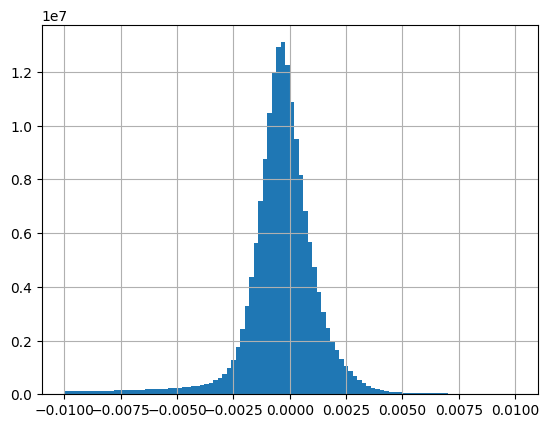

In [3]:
bedDf[(bedDf.score > -0.01) & (bedDf.score < 0.01)].score.hist(bins=100)

In [4]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,0,6,TTTTCTT,0.000064,ALF22G140,7
1,1,7,9,ACC,-0.000395,ALF22G140,3
2,1,10,13,GACA,0.001573,ALF22G140,4
3,1,14,18,AGAAT,-0.000986,ALF22G140,5
4,1,19,25,TAATTAT,0.000795,ALF22G140,7
...,...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044,3
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044,6
176721939,5,181674,181676,GCA,-0.003468,AH21C044,3
176721940,5,181677,181680,TCCA,-0.000228,AH21C044,4


In [5]:
len(bedDf.tokens.unique())

3894

In [6]:
highscoreCutoff = bedDf.score.mean() + 3 * bedDf.score.std()
highscoreCutoff

np.float64(0.012133979502852287)

In [7]:
highscoreDf = bedDf[bedDf.score > highscoreCutoff]
highscoreDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
13703,1,75447,75454,TATACTTT,0.013623,ALF22G140,8
13723,1,75557,75561,AATGA,0.014487,ALF22G140,5
13725,1,75567,75572,CCTGAG,0.015546,ALF22G140,6
13753,1,75724,75731,CTGCACCC,0.018303,ALF22G140,8
13785,1,75898,75902,GAGCA,0.018827,ALF22G140,5
...,...,...,...,...,...,...,...
176698433,5,50635,50641,AATGTTT,0.016897,AH21C044,7
176698449,5,50725,50728,ACTG,0.020198,AH21C044,4
176698513,5,51074,51079,GGCGCG,0.015019,AH21C044,6
176698639,5,51802,51807,AAATAT,0.013009,AH21C044,6


In [8]:
len(highscoreDf.tokens.unique())

1991

In [9]:
highscoreDf.shape

(286987, 7)

<Axes: >

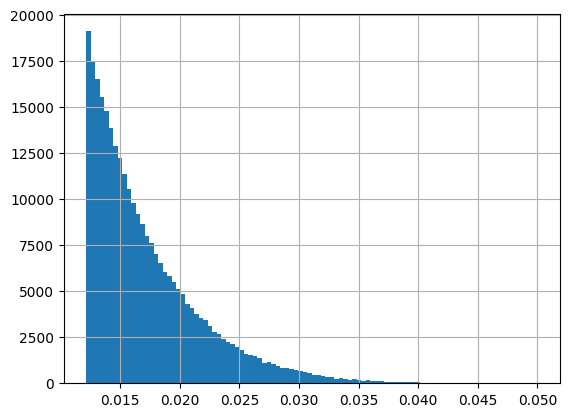

In [10]:
highscoreDf[(highscoreDf.score < 0.05)].score.hist(bins=100)

In [11]:
highscoreDf.token_length.value_counts()

token_length
6     104579
5      75597
7      51246
4      33151
8      16706
3       2680
9       1348
10       798
2        738
13        73
1         68
11         3
Name: count, dtype: int64

<Axes: xlabel='token_length', ylabel='Count'>

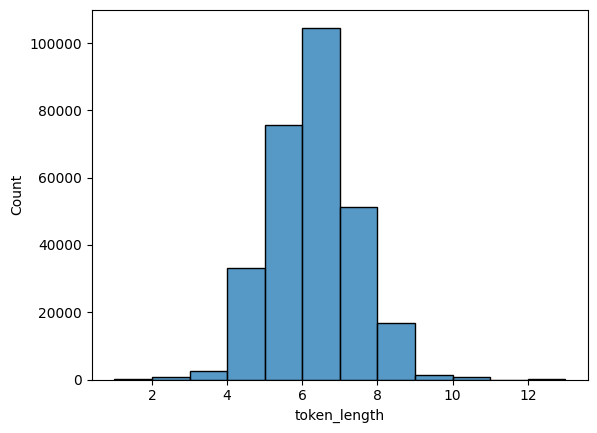

In [12]:
import seaborn as sns

sns.histplot(highscoreDf.token_length, binwidth=1)

## Read bed files containing overlapping tokens and attribution scores

In [13]:
from tqdm import tqdm

import os
import pandas as pd
from pathlib import Path


annotationOverlappingFilesDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'overlapping_with_annotations', 'SAUR')

annotationOverlappingDfList = []
for annotationOverlappingFile in tqdm(os.listdir(annotationOverlappingFilesDir)):
    df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
    df = df[df.feature_type.isin(['CDS', 'ncRNA', 'oriC', 'regulatory_region', 'oriT'])]
    df['tube_code'] = [annotationOverlappingFile.split('_')[0]]*df.shape[0]
    df = df[df.tokens.apply(lambda x: (len(x) >= 5))].reset_index()
    df['gene'] = df.gene.str.lower()
    annotationOverlappingDfList.append(df)
annotationOverlappingDf = pd.concat(annotationOverlappingDfList, ignore_index=True)
annotationOverlappingDf = annotationOverlappingDf.drop_duplicates()
annotationOverlappingDf

  0%|          | 0/515 [00:00<?, ?it/s]

 13%|█▎        | 66/515 [00:53<05:52,  1.27it/s]/tmp/ipykernel_1111380/1662500944.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
 24%|██▎       | 122/515 [01:39<04:24,  1.49it/s]/tmp/ipykernel_1111380/1662500944.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(annotationOverlappingFilesDir, annotationOverlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
 33%|███▎      | 172/515 [02:21<04:25,  1.29it/s]/tmp/ipykernel_1111380/1662500944.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=Fa

,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code
0,3,1,138,145,AAAGTAAA,0.009005,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
1,4,1,146,151,AGATAT,-0.010377,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
2,6,1,156,160,GTTGA,-0.016608,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
3,8,1,164,169,TTTAGG,-0.011910,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
4,9,1,170,175,TGTAGA,0.002626,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
...,...,...,...,...,...,...,...,...,...,...,...,...
110816017,337313,5,205763,205769,ATGATAT,0.002546,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulo,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:UPI0001DDA595,UniRef:UniRef100_A0A0D1JKS9,UniRef:UniRef50_A0A0D1JKS9,UniRef:UniRef90_A0A0D1JKS9;gene=pulO",AH21K020
110816018,337314,5,205770,205775,CCATCA,0.000022,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulo,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:UPI0001DDA595,UniRef:UniRef100_A0A0D1JKS9,UniRef:UniRef50_A0A0D1JKS9,UniRef:UniRef90_A0A0D1JKS9;gene=pulO",AH21K020
110816019,337315,5,205776,205781,ATTTTT,-0.002056,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulo,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:UPI0001DDA595,UniRef:UniRef100_A0A0D1JKS9,UniRef:UniRef50_A0A0D1JKS9,UniRef:UniRef90_A0A0D1JKS9;gene=pulO",AH21K020
110816020,337316,5,205782,205787,AGGAGG,0.000008,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulo,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:U

In [14]:
from tqdm import tqdm


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrOverlappingDfList = []
for tubeId in tqdm(bedDf.tube_id.unique()):
    tubeidHighscoreDf = highscoreDf[highscoreDf.tube_id == tubeId]
    amrfinderFile = Path(amrfinderDir, tubeId + '_amr_results.txt')
    if(amrfinderFile.exists()):
        amrfinderDf = pd.read_csv(amrfinderFile, sep='\t')
        mergedDf = tubeidHighscoreDf.merge(
            amrfinderDf,
            how='inner',
            left_on = ['contig_id'],
            right_on = ['Contig id'],
        )
        mergedDf['tube_code'] = tubeId
        tubeidOverlappingDf = mergedDf[(mergedDf.start_position >= mergedDf.Start) & (mergedDf.end_position <= mergedDf.Stop)]
        amrOverlappingDfList.append(tubeidOverlappingDf)

amrOverlappingDf = pd.concat(amrOverlappingDfList, ignore_index=True)
amrOverlappingDf

100%|██████████| 557/557 [00:09<00:00, 59.46it/s]


,contig_id,start_position,end_position,tokens,score,tube_id,token_length,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description,tube_code
0,3,92632,92637,TGAAGT,0.016457,ALF22G140,6,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
1,3,92734,92739,TAAACT,0.012154,ALF22G140,6,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
2,3,93110,93114,AAAAC,0.013360,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
3,3,93281,93285,GAGTA,0.012412,ALF22G140,5,NaN,3,92622,93371,+,sel26,staphylococcal enterotoxin type 26,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,250,250,100.0,94.80,250,KAG18833.1,staphylococcal enterotoxin type 26,NaN,NaN,ALF22G140
4,5,115189,115193,CCAAT,0.013918,AH20K063,5,NaN,5,113439,115193,+,blaR1,beta-lactam sensor/signal transducer BlaR1,core,AMR,AMR,BETA-LACTAM,BETA-LACTAM,BLASTX,585,585,100.0,91.45,585,WP_001096386.1,beta-lactam sensor/signal transducer BlaR1,NaN,NaN,AH20K063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,3,313940,313945,CAGGTG,0.012849,AH20L076,6,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1607,3,313975,313979,CTTTG,0.014194,AH20L076,5,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1608,3,314026,314030,ACAGT,0.012561,AH20L076,5,NaN,3,312704,314056,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.0,99.56,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN,AH20L076
1609,1,464540,464543,TTGA,0.013898,AH21C044,4,NaN,1,464367,465893,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.0,99.21,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN,AH21C044


In [52]:
overlappingDf = pd.concat(
    [
        annotationOverlappingDf[['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'gene', 'name', 'tube_code']],
        amrOverlappingDf[['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'Gene symbol', 'Sequence name', 'tube_code']].rename(columns={'Gene symbol': 'gene', 'Sequence name': 'name'})
    ],
    names=['contig_id', 'start_position', 'end_position', 'tokens', 'gene'],
    ignore_index=False
)
overlappingDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,138,145,AAAGTAAA,0.009005,acpp,acyl carrier protein,AH20I016
1,1,146,151,AGATAT,-0.010377,acpp,acyl carrier protein,AH20I016
2,1,156,160,GTTGA,-0.016608,acpp,acyl carrier protein,AH20I016
3,1,164,169,TTTAGG,-0.011910,acpp,acyl carrier protein,AH20I016
4,1,170,175,TGTAGA,0.002626,acpp,acyl carrier protein,AH20I016
...,...,...,...,...,...,...,...,...
1606,3,313940,313945,CAGGTG,0.012849,mepA,multidrug efflux MATE transporter MepA,AH20L076
1607,3,313975,313979,CTTTG,0.014194,mepA,multidrug efflux MATE transporter MepA,AH20L076
1608,3,314026,314030,ACAGT,0.012561,mepA,multidrug efflux MATE transporter MepA,AH20L076
1609,1,464540,464543,TTGA,0.013898,aur,zinc metalloproteinase aureolysin,AH21C044


## Get overlapping tokens for high-score tokens

In [53]:
highscoreTokenOverlapsDf = overlappingDf.merge(
    highscoreDf[['contig_id', 'start_position', 'end_position', 'tokens']],
    on=['contig_id', 'start_position', 'end_position', 'tokens'],
    how='inner',
)
highscoreTokenOverlapsDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,212,217,TGATTT,0.016428,acpp,acyl carrier protein,AH20I016
1,1,302,309,AAAAATCA,0.012217,acpp,acyl carrier protein,AH20I016
2,1,483,491,AAAGAAAAG,0.018888,rnc,ribonuclease III,AH20I016
3,1,604,608,AATGA,0.015653,rnc,ribonuclease III,AH20I016
4,1,609,615,TTTTAAT,0.018532,rnc,ribonuclease III,AH20I016
...,...,...,...,...,...,...,...,...
281328,3,313975,313979,CTTTG,0.014194,mepA,multidrug efflux MATE transporter MepA,AH20L076
281329,3,314026,314030,ACAGT,0.012561,mepA,multidrug efflux MATE transporter MepA,AH20L076
281330,1,464540,464543,TTGA,0.013898,aur,zinc metalloproteinase aureolysin,AH21C044
281331,5,67876,67879,TTGA,0.013503,blaI,penicillinase repressor BlaI,AH21C044


## Calculate weighted sum for all the genes overlapping with high-score tokens

In [54]:
import numpy as np


geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
geneWeightedsumDf

/tmp/ipykernel_1111380/2423154480.py:4: FutureWarning: The provided callable <function sum at 0x7c6af84843a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,gene,weighted_sum
0,5_ureb_srna,0.061550
1,6s,1.498754
2,aaa,1.831435
3,abc-f,0.742134
4,abcc,0.076475
...,...,...
1781,zapa,1.286040
1782,znua,9.320601
1783,znub,4.685461
1784,znuc,3.138582


## Visualise weighted sum

<Axes: xlabel='weighted_sum', ylabel='Count'>

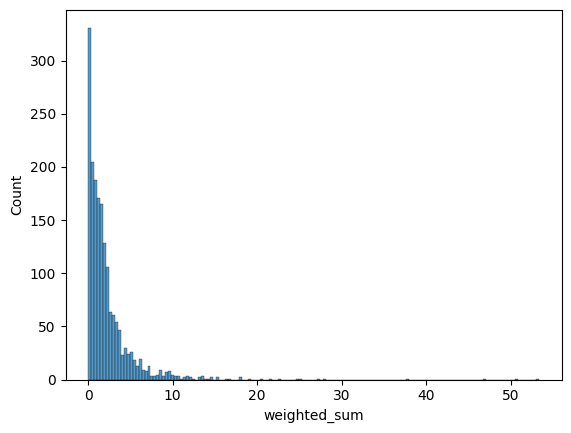

In [55]:
import seaborn as sns


sns.histplot(geneWeightedsumDf.weighted_sum)

## Top genes based on the weighted sum

In [56]:
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]

,gene,weighted_sum
363,essc,53.386270
358,esad,50.876464
487,gltb,46.922011
445,ftsk,37.587255
114,bglg,28.027139
359,esae,27.382075
706,lys2b,25.063095
357,esac,24.748311
330,ebh,22.504625
1050,ptsg,21.585067


## Create gene-type lookup table from amrfinderplus annotations

In [57]:
import os

import pandas as pd

from pathlib import Path


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrfinderDfList = []
for amrfinderFile in os.listdir(amrfinderDir):
    amrfinderDf = pd.read_csv(Path(amrfinderDir, amrfinderFile), sep='\t')
    amrfinderDfList.append(amrfinderDf)

allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)
allAmrfinderDf

/tmp/ipykernel_1111380/536070399.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)


,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description
0,NaN,1,83926,85452,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.00,99.41,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN
1,NaN,1,128415,129464,+,icaC,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,350,350,100.00,100.00,350,AUU58561.1,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,NaN,NaN
2,NaN,1,150950,154498,-,cna,collagen adhesin Cna,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1183,1183,100.00,98.31,1183,BAB96477.1,collagen adhesin Cna,NaN,NaN
3,NaN,1,277464,278813,+,tet(38),tetracycline efflux MFS transporter Tet(38),core,AMR,AMR,TETRACYCLINE,TETRACYCLINE,EXACTX,450,450,100.00,100.00,450,WP_001100300.1,tetracycline efflux MFS transporter Tet(38),NaN,NaN
4,NaN,1,505300,506652,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.00,99.33,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57610,NaN,17,83399,84580,-,emrD,multidrug efflux MFS transporter EmrD,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,394,394,100.00,99.24,394,ACN65732.1,multidrug efflux MFS transporter EmrD,NaN,NaN
57611,NaN,2,213498,214724,-,kdeA,multidrug efflux MFS transporter KdeA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,409,410,99.76,99.02,409,ABR76310.1,multidrug efflux MFS transporter KdeA,NaN,NaN
57612,NaN,3,59710,60882,+,oqxA,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,BLASTX,391,391,100.00,99.23,391,WP_002914189.1,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,NaN,NaN
57613,NaN,3,60909,64058,+,oqxB9,multidrug efflux RND transporter permease subunit OqxB9,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,ALLELEX,1050,1050,100.00,100.00,1050,WP_012967412.1,multidrug efflux RND transporter permease subunit OqxB9,NaN,NaN


In [58]:
genetypeLookupDf = allAmrfinderDf[['Gene symbol', 'Element type']].drop_duplicates()
genetypeLookupDf['Gene symbol'] = genetypeLookupDf['Gene symbol'].str.lower()
genetypeLookupDf

,Gene symbol,Element type
0,aur,VIRULENCE
1,icac,VIRULENCE
2,cna,VIRULENCE
3,tet(38),AMR
4,mepa,AMR
...,...,...
55837,blapdc-58,AMR
56358,blaact-49,AMR
56951,blandm-4,AMR
56963,aac(6')-ib-cr,AMR


## Read vfdb info

In [59]:
import os
import pandas as pd
from pathlib import Path


vfdbInfoFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'VFDB_info.csv')
vfdbInfoDf = pd.read_csv(vfdbInfoFile)
vfdbInfoDf['Label'] = vfdbInfoDf['Label'].str.lower()
vfdbInfoDf

,Column,ID,Label,Description,Source,Class
0,1,c0393,vat,hemoglobin protease,Escherichia coli O6:K2:H1 CFT073 (UPEC),Autotransporters
1,2,APECO1_O1CoBM73,tsh,Tsh,Escherichia coli O1:K1:H7 (APEC),Autotransporters
2,3,Q673F0_ECOLX,rpea,putative SPATE autotransporter; similar to the SPATE proteins,Escherichia coli plasmid pRAP strain REPEC 83/39,Autotransporters
3,4,ECSF_4010,ecsf_4010,phage protein,Escherichia coli SE15,Autotransporters
4,5,EcSMS35_3921,ecsms35_3921,outer membrane autotransporter,Escherichia coli SMS-3-5 (environmental),Autotransporters
...,...,...,...,...,...,...
249,250,c5077,yddo,ABC transporter ATP-binding protein,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
250,251,c5078,c5078,oligopeptide ABC transporter,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
251,252,c5079,yddq,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
252,253,c5080,yddr,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes


## Read vf collection

In [60]:
import os
import pandas as pd
from pathlib import Path


vfCollectionDescriptionFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ecoli_VF_collection_description.tsv')
vfCollectionDescriptionDf = pd.read_csv(vfCollectionDescriptionFile, sep='\t')
vfCollectionDescriptionDf['gene'] = vfCollectionDescriptionDf['gene'].str.lower()
vfCollectionDescriptionDf

,gene,locus tag,accession number (protein_id),description,reference,source,class
0,aap,EC042_pAA055,NaN,dispersin,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
1,aata,EC042_pAA008,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
2,aatb,EC042_pAA009,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
3,aatc,EC042_pAA010,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
4,aatd,EC042_pAA011,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
...,...,...,...,...,...,...,...
1064,lngj,NaN,ABU50049,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1065,lngp,NaN,ABU50050,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1066,etsa,APECO1_O1CoBM197,YP_001481352,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene
1067,etsb,APECO1_O1CoBM198,YP_001481353,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene


## Read ABRicate

In [61]:
import os
import pandas as pd
from pathlib import Path


abricateFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ABRicate.csv')
abricateDf = pd.read_csv(abricateFile)
abricateDf['gene'] = abricateDf['gene'].str.lower()
abricateDf

,gene,type
0,aaa23990,heat-stable enterotoxin
1,aaa24093,heat labile enterotoxin type IIa A
2,aaa24094,heat labile enterotoxin type IIa B
3,apeco1_1753,hypothetical protein
4,apeco1_1761,hypothetical protein
...,...,...
2696,ygeh,transcriptional regulator
2697,yggr,
2698,yghg,
2699,yijp,


## Add gene descriptions to the top genes

In [62]:
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20].merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates()

,gene,name,weighted_sum,AMR Finder Type,VFDB Type,VF Collection Type
0,essc,type VII secretion system protein EssC%2C FtsK/SpoIIIE family ATPase,53.386270,NaN,NaN,NaN
1,essc,type VII secretion protein EssC,53.386270,NaN,NaN,NaN
2,esad,type VII secretion system secreted protein%2C a nuclease toxin EsaD,50.876464,NaN,NaN,NaN
3,gltb,glutamate synthase large subunit,46.922011,NaN,NaN,NaN
4,ftsk,DNA segregation ATPase FtsK/SpoIIIE or related protein,37.587255,NaN,NaN,NaN
5,ftsk,DNA translocase FtsK,37.587255,NaN,NaN,NaN
6,bglg,Transcriptional antiterminator,28.027139,NaN,NaN,NaN
7,bglg,BglG family transcription antiterminator,28.027139,NaN,NaN,NaN
8,esae,type VII secretion system chaperone protein,27.382075,NaN,NaN,NaN
9,lys2b,Thioester reductase domain of alpha aminoadipate reductase Lys2 and NRPSs,25.063095,NaN,NaN,NaN


## Save all gene hits

In [63]:
import os
import pandas as pd
from pathlib import Path


outputFile = Path(os.environ['GENOMICS_DATA_BASE'], 'temp', 'saur_top_genes_all_overlaping_3sd_tokens.csv')
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False).merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates().to_csv(outputFile, index=False)

## Read mapping information

In [64]:
import os

import pandas as pd


demoTrainDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_train.csv', sep='\t')
demoTestDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_test.csv', sep='\t')
demoValidateDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_validate.csv', sep='\t')
demoDf = pd.concat([demoTrainDf, demoTestDf, demoValidateDf], ignore_index=True)
demoDf

,person_id,visit_occurrence_id,TYPE,COUNTRY_OF_BIRTH,SEX,Age_Bin,JOURNEY_ID
0,678487,3312694,Emergency,Australia,Male,"(60, 70]",3312694
1,2094045,9199249,Emergency,Australia,Male,"(20, 30]",9199249
2,2107813,9410987,Emergency,Australia,Male,"(50, 60]",9410987
3,2083212,602890,Inpatient,Australia,Female,"(40, 50]",9039437
4,2083212,9039437,Emergency,Australia,Female,"(40, 50]",9039437
...,...,...,...,...,...,...,...
7194,2603535,16588204,Inpatient,Australia,Male,"(60, 70]",16588204
7195,2603535,16709341,Inpatient,Australia,Male,"(60, 70]",16709341
7196,2603535,16651755,Inpatient,Australia,Male,"(60, 70]",16651755
7197,2098616,16872774,Emergency,Australia,Female,"(80, 90]",16872774


In [65]:
import os

mappingDf = pd.read_csv(os.environ['GENOMICS_DATA_BASE'] + '/patient_tube_id_mapping_full.tsv', sep='\t')
mappingDf

,tube_code,PATIENT_ID,db_ID,pt_age,pt_gender,EPISODE_ID,hospital_admission,hospital_discharge,hospital_in_last_year,genome_species,species_reported,contig_number,length,tube_code_duplicate_or_old,date_of_collection,ID_number,location_additional_02,collected_from_original
0,AH19J072,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Escherichia coli,Escherichia coli,92,5131021,NaN,2019-10-30,19-303-0997,A-7EA;HAEM,Blood
1,AH19J074,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Streptococcus sp. D19,Streptococcus mitis group,84,2022991,NaN,2019-10-30,19-303-1174,A-7EA;HAEM,Blood Peripheral
2,AH19B003,526238.0,567AE,85,Male,640261.0,2019-02-04,2019-02-07,no,Escherichia coli,Escherichia coli,93,4942915,NaN,2019-02-03,19-034-1596,A-4WB;GMC,Blood
3,AH20A024,788941.0,3YBDS,58,Female,13194824.0,2020-01-16,2020-01-19,no,Escherichia coli,Escherichia coli,110,5149157,NaN,2020-01-16,20-016-2112,S-ED;Emergency,Blood Venous
4,AH20L041,1023735.0,2VJ78,42,Male,14210147.0,2020-12-18,2021-01-05,yes,Staphylococcus aureus,Staphylococcus aureus,46,2735216,NaN,2020-12-16,20-351-2856,Emergency Dept;nan,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,ALF22L076,639020.0,3S6HL,84,Male,17219899.0,2022-12-15,2022-12-20,yes,Streptococcus vestibularis,Streptococcus salivarius group,107,1938627,NaN,2022-12-15,22-349-2150,Ward 4WB,Blood Peripheral
3113,ALF22L089,655404.0,6EWBM,67,Female,NaN,NaN,NaN,NaN,Proteus columbae,Proteus vulgaris,152,3972219,NaN,2022-12-17,22-351-1465,Comm/Amb Clinic,Blood
3114,ALF22L138,2572048.0,YM5PJ,61,Male,NaN,NaN,NaN,NaN,Enterobacter roggenkampii,Enterobacter cloacae complex,66,4876179,NaN,2022-12-27,22-361-0202,Ward 7 East,Hick White Lum
3115,ALF23A102,2054964.0,5DYAH,35,Female,17294287.0,2023-01-12,2023-02-01,yes,Streptococcus constellatus,Streptococcus anginosus group,54,1869828,NaN,2023-01-11,23-011-3305,ICU,Blood Venous


In [66]:
mappedJourneyTubeIdsDf = mappingDf[['tube_code', 'PATIENT_ID', 'EPISODE_ID']].drop_duplicates().merge(
    demoDf[['person_id', 'visit_occurrence_id', 'JOURNEY_ID']],
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
).drop(
    columns=['PATIENT_ID', 'EPISODE_ID', 'visit_occurrence_id']
)[['person_id', 'JOURNEY_ID', 'tube_code']].drop_duplicates()
mappedJourneyTubeIdsDf

,person_id,JOURNEY_ID,tube_code
0,50056,13224842,AH20B011
1,62567,12645629,AH19G065
2,138108,14737781,AH21E052
3,211314,13955099,AH20J009
4,211314,13955099,KPN2214
...,...,...,...
512,2084373,16158768,ALF22C004
513,1058066,16759482,ALF22H089
514,2552781,16966609,ALF22J054
515,2638484,16969999,ALF22K143


## Read mortality labels

In [135]:
import os

import pandas as pd

from pathlib import Path


mortalityTrainDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_train.csv'), sep='\t')
mortalityTestDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_test.csv'), sep='\t')
mortalityValidateDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_7_day_normal_validate.csv'), sep='\t')
mortality7Df = pd.concat([mortalityTrainDf, mortalityTestDf, mortalityValidateDf], ignore_index=True).drop_duplicates()
mortality7Df

,person_id,JOURNEY_ID,visit_occurrence_id,death_7_day
0,678487,3312694,3312694,0
1,2094045,9199249,9199249,0
4,2107813,9410987,9410987,1
8,2083212,9039515,9039515,0
9,2083212,9039437,602890,0
...,...,...,...,...
34962,2603535,16709341,16709341,0
34963,2603535,16651755,16651755,0
34970,2603535,16588204,16588204,0
34984,2098616,16872774,16872774,0


In [136]:
import os

import pandas as pd

from pathlib import Path


mortalityTrainDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_train.csv'), sep='\t')
mortalityTestDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_test.csv'), sep='\t')
mortalityValidateDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_3', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_validate.csv'), sep='\t')
mortality30Df = pd.concat([mortalityTrainDf, mortalityTestDf, mortalityValidateDf], ignore_index=True).drop_duplicates()
mortality30Df

,person_id,JOURNEY_ID,visit_occurrence_id,death_30_day
0,678487,3312694,3312694,0
1,2094045,9199249,9199249,0
4,2107813,9410987,9410987,1
8,2083212,9039515,9039515,0
9,2083212,9039437,602890,0
...,...,...,...,...
34962,2603535,16709341,16709341,0
34963,2603535,16651755,16651755,0
34970,2603535,16588204,16588204,0
34984,2098616,16872774,16872774,0


In [137]:
import pandas as pd


mortalityDf = mortality7Df.merge(
    mortality30Df,
    how='inner',
    on=['person_id', 'JOURNEY_ID', 'visit_occurrence_id']
)
# mortalityDf = mortality30Df
mortalityDf

,person_id,JOURNEY_ID,visit_occurrence_id,death_7_day,death_30_day
0,678487,3312694,3312694,0,0
1,2094045,9199249,9199249,0,0
2,2107813,9410987,9410987,1,1
3,2083212,9039515,9039515,0,0
4,2083212,9039437,602890,0,0
...,...,...,...,...,...
7290,2603535,16709341,16709341,0,0
7291,2603535,16651755,16651755,0,0
7292,2603535,16588204,16588204,0,0
7293,2098616,16872774,16872774,0,0


## Create annotations data matrix

In [138]:
geneWeightedsumDf

,gene,weighted_sum
0,5_ureb_srna,0.061550
1,6s,1.498754
2,aaa,1.831435
3,abc-f,0.742134
4,abcc,0.076475
...,...,...
1781,zapa,1.286040
1782,znua,9.320601
1783,znub,4.685461
1784,znuc,3.138582


In [139]:
signatureAnnotationsDf = highscoreTokenOverlapsDf[highscoreTokenOverlapsDf['gene'].isin(geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]['gene'])]
signatureAnnotationsDf


,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
51,1,104059,104064,GATGTG,0.027761,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
52,1,104122,104128,AAAATGG,0.014966,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
53,1,104373,104377,TTTGT,0.016255,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
54,1,104463,104469,CCAACAT,0.020258,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
55,1,104625,104630,AATGAT,0.014629,ccma,ABC-type multidrug transport system%2C ATPase component,AH20I016
...,...,...,...,...,...,...,...,...
281259,1,358534,358539,TAAAGG,0.013273,tet(38),tetracycline efflux MFS transporter Tet(38),AH21A011
281260,1,358734,358737,AACC,0.015188,tet(38),tetracycline efflux MFS transporter Tet(38),AH21A011
281261,1,358845,358851,CTATAAA,0.016098,tet(38),tetracycline efflux MFS transporter Tet(38),AH21A011
281262,1,358993,358997,CATGA,0.013797,tet(38),tetracycline efflux MFS transporter Tet(38),AH21A011


In [140]:
signatureDataDf = signatureAnnotationsDf[['tube_code', 'gene']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['gene'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('gene',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf

,tube_code,acoa,acob,araj,bglg,ccma,ebh,esac,esad,esae,essc,fadb,ftsk,gltb,lys2b,lysr,polc,ptsg,qri1,sbcc,tet(38)
51,AH20I016,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
102,AH20I016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
207,AH20I016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
214,AH20I016,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
588,AH20I016,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279530,ALF22J050,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
279644,ALF23C003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
279887,ALF23C094,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
279920,AH20H052,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Create datamatrix

In [141]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='inner'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_7_day,death_30_day,acoa,acob,araj,bglg,ccma,ebh,esac,esad,esae,essc,fadb,ftsk,gltb,lys2b,lysr,polc,ptsg,qri1,sbcc,tet(38)
0,2154700,10220218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2145022,601149,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2145022,601149,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2145022,601149,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2145022,601149,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,1733673,16562760,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
231,1733673,16562760,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
232,2515966,16640224,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
233,2515966,16640224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Calculate correlation

In [142]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_7_day,death_30_day,acoa,acob,araj,bglg,ccma,ebh,esac,esad,esae,essc,fadb,ftsk,gltb,lys2b,lysr,polc,ptsg,qri1,sbcc,tet(38)
death_30_day,0.625633,1.000000,0.010528,0.010528,0.043431,-0.010782,-0.034305,-0.031525,-0.019773,0.029199,0.029199,-0.082244,0.015019,0.024401,0.071946,0.016015,-0.088896,-0.110990,0.098390,-0.077624,0.065448,0.029947
death_7_day,1.000000,0.625633,0.067370,0.067370,0.041631,-0.027422,0.011475,0.026527,-0.053316,-0.057714,-0.057714,-0.079706,-0.061834,-0.049138,0.096112,-0.002777,-0.022399,-0.069439,0.104827,-0.048564,0.050676,0.062605
ptsg,0.104827,0.098390,-0.040135,-0.040135,-0.098021,-0.079640,-0.112173,-0.053441,-0.049369,-0.053441,-0.053441,-0.073806,-0.057257,-0.093023,-0.057257,-0.095543,-0.076765,-0.064299,1.000000,-0.044969,-0.044969,-0.067588
gltb,0.096112,0.071946,-0.024703,-0.024703,-0.060333,-0.049019,-0.069044,-0.032894,-0.030387,-0.032894,-0.032894,-0.045428,-0.035242,-0.057257,1.000000,-0.058808,-0.047250,-0.039577,-0.057257,-0.027679,-0.027679,-0.041601
sbcc,0.050676,0.065448,-0.019402,-0.019402,-0.047385,-0.038500,-0.054227,-0.025835,-0.023866,-0.025835,-0.025835,-0.035679,-0.027679,-0.044969,-0.027679,-0.046187,-0.037110,-0.031083,-0.044969,-0.021739,1.000000,-0.032673
araj,0.041631,0.043431,-0.042291,-0.042291,1.000000,-0.083918,-0.118199,-0.056312,-0.052021,-0.056312,-0.056312,-0.077771,-0.060333,-0.098021,-0.060333,-0.100676,-0.080889,-0.067753,-0.098021,-0.047385,-0.047385,-0.071219
tet(38),0.062605,0.029947,-0.029161,-0.029161,-0.071219,-0.057864,-0.081502,-0.038829,-0.035870,-0.038829,-0.038829,-0.053625,-0.041601,-0.067588,-0.041601,-0.069418,-0.055775,-0.046718,-0.067588,-0.032673,-0.032673,1.000000
esad,-0.057714,0.029199,-0.023057,-0.023057,-0.056312,-0.045753,-0.064443,-0.030702,-0.028362,1.000000,-0.030702,-0.042401,-0.032894,-0.053441,-0.032894,-0.054889,-0.044101,-0.036939,-0.053441,-0.025835,-0.025835,-0.038829
esae,-0.057714,0.029199,-0.023057,-0.023057,-0.056312,-0.045753,-0.064443,-0.030702,-0.028362,-0.030702,1.000000,-0.042401,-0.032894,-0.053441,-0.032894,-0.054889,-0.044101,-0.036939,-0.053441,-0.025835,-0.025835,-0.038829
ftsk,-0.049138,0.024401,-0.040135,-0.040135,-0.098021,-0.079640,-0.112173,-0.053441,-0.049369,-0.053441,-0.053441,-0.073806,-0.057257,1.000000,-0.057257,-0.095543,-0.076765,-0.064299,-0.093023,-0.044969,-0.044969,-0.067588


### Plot correlations as a heatmap

<Axes: >

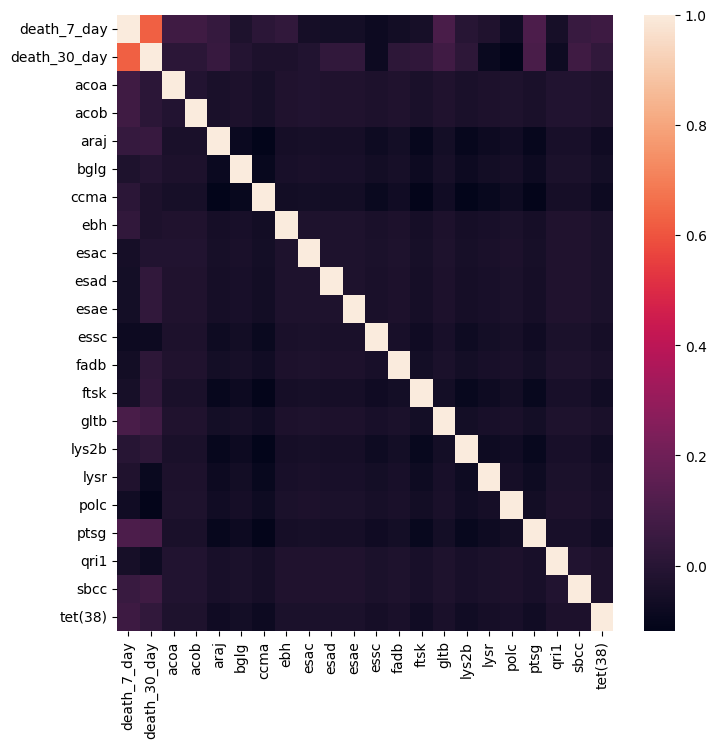

In [143]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr())

### Plot correlations as a heatmap (Log scale)

<Axes: >

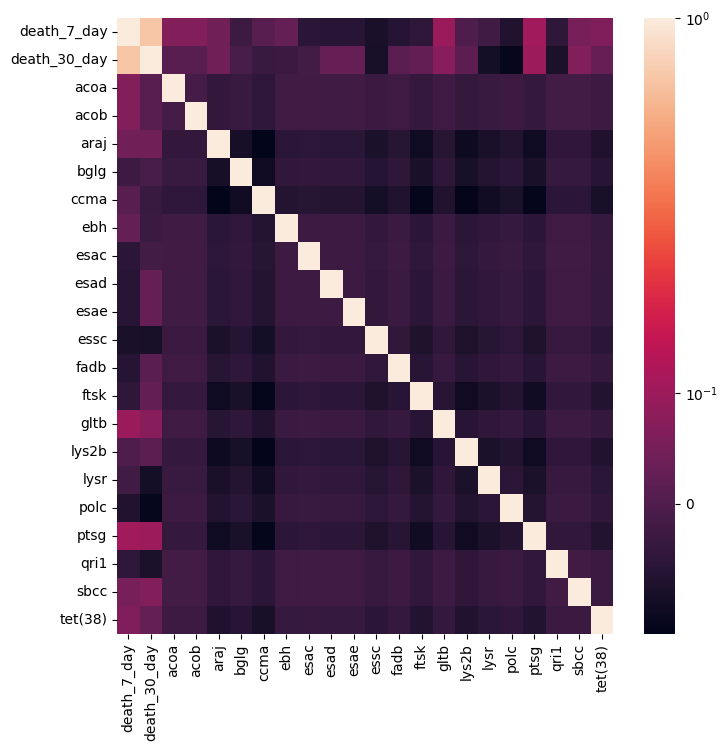

In [144]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr(), norm=SymLogNorm(linthresh=0.3))

### Plot correlations as a heatmap (Log scale - Sorted)

<Axes: >

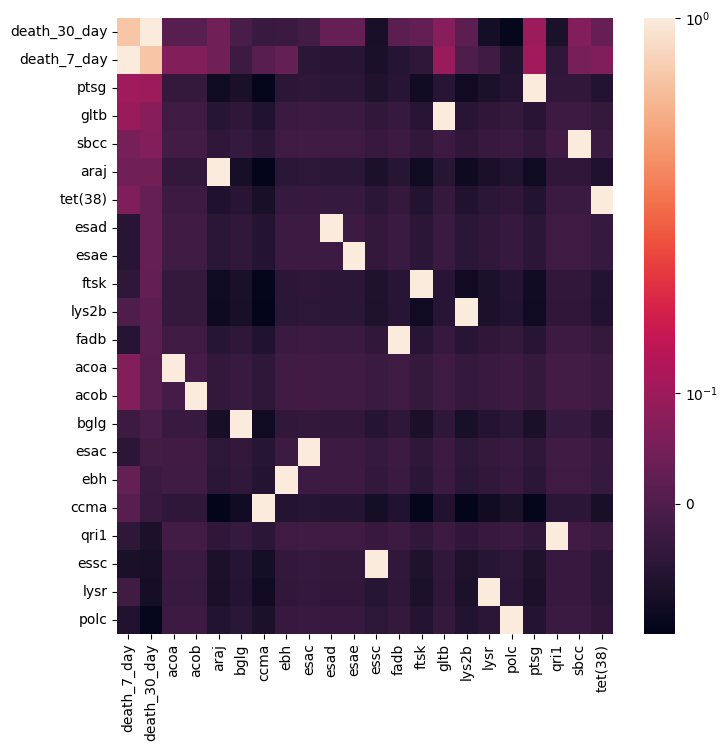

In [145]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False), norm=SymLogNorm(linthresh=0.3))

### Model using machine learning (7 day mortality)

In [165]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_7_day', 'death_30_day'])
y = dataDf.death_7_day

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.2978723404255319
Balanced Accuracy:  0.38953488372093026
Average Precision:  0.07285622179239201
F1 Score:  0.10810810810810811
ROC AUC:  0.38953488372093026


In [167]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.9148936170212766
Balanced Accuracy:  0.5
Average Precision:  0.0851063829787234
F1 Score:  0.0
ROC AUC:  0.5


In [168]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
15,polc,-0.555281
9,essc,-0.555281
10,fadb,-0.436801
19,tet(38),-0.436801
8,esae,-0.391280
7,esad,-0.391280
6,esac,-0.287801
17,qri1,-0.228120
11,ftsk,-0.177580
3,bglg,-0.055162


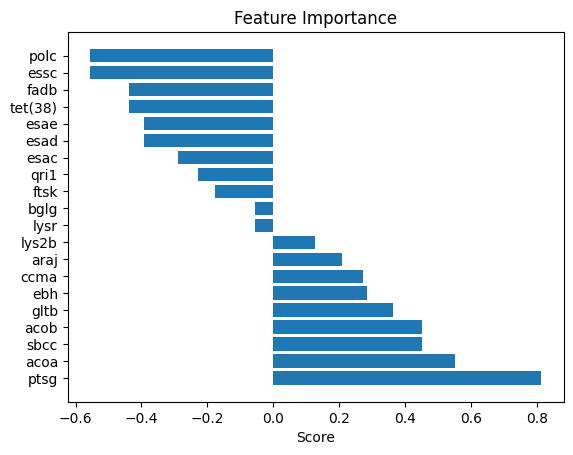

In [169]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()


### Model using machine learning (30 day mortality)

In [170]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_7_day', 'death_30_day'])
y = dataDf.death_30_day

In [171]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.2765957446808511
Balanced Accuracy:  0.5277777777777778
Average Precision:  0.24444444444444444
F1 Score:  0.39285714285714285
ROC AUC:  0.5277777777777778


In [172]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.7659574468085106
Balanced Accuracy:  0.5
Average Precision:  0.23404255319148937
F1 Score:  0.0
ROC AUC:  0.5


In [173]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
15,polc,-0.943134
14,lysr,-0.568580
9,essc,-0.450434
17,qri1,-0.445122
19,tet(38),-0.228019
4,ccma,-0.182531
5,ebh,-0.135767
11,ftsk,-0.046654
12,gltb,-0.030102
13,lys2b,0.051973


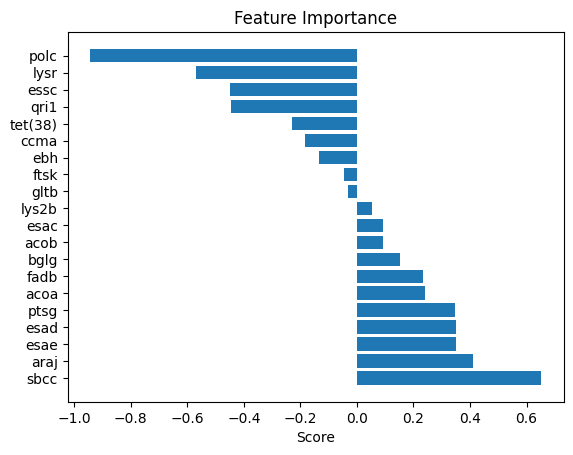

In [174]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()


## Create tokens data matrix

In [190]:
import numpy as np


tokenWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['tokens']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
tokenWeightedsumDf

/tmp/ipykernel_1111380/457035517.py:4: FutureWarning: The provided callable <function sum at 0x7c6af84843a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tokenWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['tokens']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,tokens,weighted_sum
0,AAAAAA,0.043837
1,AAAAAAA,2.032105
2,AAAAAAT,0.342919
3,AAAAAATTA,0.187351
4,AAAAACAA,1.457375
...,...,...
1454,TTTTGTTTT,0.027434
1455,TTTTTAA,0.671302
1456,TTTTTCA,3.878010
1457,TTTTTCT,0.279267


In [191]:
signatureTokensDf = highscoreTokenOverlapsDf[highscoreTokenOverlapsDf['tokens'].isin(tokenWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]['tokens'])]
signatureTokensDf

,contig_id,start_position,end_position,tokens,score,gene,name,tube_code
0,1,212,217,TGATTT,0.016428,acpp,acyl carrier protein,AH20I016
23,1,13080,13084,TTTGT,0.014794,yfho,lipoteichoic acid-specific glycosyltransferase YfhO,AH20I016
30,1,43186,43191,CAATAA,0.015891,rimp,ribosome maturation factor RimP,AH20I016
33,1,44362,44366,CCAGT,0.012659,nusa,Transcription antitermination factor NusA%2C contains S1 and KH domains,AH20I016
38,1,102681,102686,AAACAT,0.013746,cls,cardiolipin synthase,AH20I016
...,...,...,...,...,...,...,...,...
281308,3,312909,312914,TAATTT,0.015043,mepA,multidrug efflux MATE transporter MepA,AH20L076
281313,3,313125,313131,AATGTTT,0.015912,mepA,multidrug efflux MATE transporter MepA,AH20L076
281315,3,313171,313176,CAATTT,0.025049,mepA,multidrug efflux MATE transporter MepA,AH20L076
281318,3,313529,313533,ATGGT,0.019383,mepA,multidrug efflux MATE transporter MepA,AH20L076


In [192]:
signatureDataDf = signatureTokensDf[['tube_code', 'tokens']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['tokens'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('tokens',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf


,tube_code,AAAATGT,AAACAT,AACAC,AATGTTT,ATGGT,CAATAA,CAATTT,CACCGT,CATAC,CCAGT,CCTTTT,CTTAC,GAAAG,GGTCT,TAATTT,TGATTT,TTGCAA,TTGTG,TTGTTTA,TTTGT
0,AH20I016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
23,AH20I016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
30,AH20I016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33,AH20I016,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
38,AH20I016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281119,ALF23C174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
281122,ALF23C174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
281123,ALF23C174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
281124,ALF23C174,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Create datamatrix

In [193]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='inner'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_7_day,death_30_day,AAAATGT,AAACAT,AACAC,AATGTTT,ATGGT,CAATAA,CAATTT,CACCGT,CATAC,CCAGT,CCTTTT,CTTAC,GAAAG,GGTCT,TAATTT,TGATTT,TTGCAA,TTGTG,TTGTTTA,TTTGT
0,2154700,10220218,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2154700,10220218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2154700,10220218,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2154700,10220218,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2154700,10220218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1347,2515966,16640224,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1348,2515966,16640224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1349,2515966,16640224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1350,2515966,16640224,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Calculate correlation

In [194]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_7_day,death_30_day,AAAATGT,AAACAT,AACAC,AATGTTT,ATGGT,CAATAA,CAATTT,CACCGT,CATAC,CCAGT,CCTTTT,CTTAC,GAAAG,GGTCT,TAATTT,TGATTT,TTGCAA,TTGTG,TTGTTTA,TTTGT
death_30_day,0.632800,1.000000,-0.000357,-0.000357,0.001579,0.003542,-0.000357,0.003542,-0.000357,0.003542,-0.004360,-0.000357,0.001579,-0.000357,-0.006268,0.007688,-0.000357,0.001579,-0.006268,-0.000357,0.003551,-0.006268
death_7_day,1.000000,0.632800,-0.000132,-0.000132,0.001094,0.002337,-0.000132,0.002337,-0.000132,0.002337,-0.008301,-0.000132,0.001094,-0.000132,0.001094,0.010193,-0.000132,0.001094,-0.009470,-0.000132,-0.003459,0.001094
GGTCT,0.010193,0.007688,-0.050410,-0.050410,-0.050023,-0.049635,-0.050410,-0.049635,-0.050410,-0.049635,-0.049635,-0.050410,-0.050023,-0.050410,-0.050023,1.000000,-0.050410,-0.050023,-0.050023,-0.050410,-0.048056,-0.050023
TTGTTTA,-0.003459,0.003551,-0.051269,-0.051269,-0.050876,-0.050481,-0.051269,-0.050481,-0.051269,-0.050481,-0.050481,-0.051269,-0.050876,-0.051269,-0.050876,-0.048056,-0.051269,-0.050876,-0.050876,-0.051269,1.000000,-0.050876
CAATAA,0.002337,0.003542,-0.052954,-0.052954,-0.052548,-0.052140,-0.052954,1.000000,-0.052954,-0.052140,-0.052140,-0.052954,-0.052548,-0.052954,-0.052548,-0.049635,-0.052954,-0.052548,-0.052548,-0.052954,-0.050481,-0.052548
CACCGT,0.002337,0.003542,-0.052954,-0.052954,-0.052548,-0.052140,-0.052954,-0.052140,-0.052954,1.000000,-0.052140,-0.052954,-0.052548,-0.052954,-0.052548,-0.049635,-0.052954,-0.052548,-0.052548,-0.052954,-0.050481,-0.052548
AATGTTT,0.002337,0.003542,-0.052954,-0.052954,-0.052548,1.000000,-0.052954,-0.052140,-0.052954,-0.052140,-0.052140,-0.052954,-0.052548,-0.052954,-0.052548,-0.049635,-0.052954,-0.052548,-0.052548,-0.052954,-0.050481,-0.052548
CCTTTT,0.001094,0.001579,-0.053368,-0.053368,-0.052960,-0.052548,-0.053368,-0.052548,-0.053368,-0.052548,-0.052548,-0.053368,1.000000,-0.053368,-0.052960,-0.050023,-0.053368,-0.052960,-0.052960,-0.053368,-0.050876,-0.052960
TGATTT,0.001094,0.001579,-0.053368,-0.053368,-0.052960,-0.052548,-0.053368,-0.052548,-0.053368,-0.052548,-0.052548,-0.053368,-0.052960,-0.053368,-0.052960,-0.050023,-0.053368,1.000000,-0.052960,-0.053368,-0.050876,-0.052960
AACAC,0.001094,0.001579,-0.053368,-0.053368,1.000000,-0.052548,-0.053368,-0.052548,-0.053368,-0.052548,-0.052548,-0.053368,-0.052960,-0.053368,-0.052960,-0.050023,-0.053368,-0.052960,-0.052960,-0.053368,-0.050876,-0.052960


### Plot correlations as a heatmap

<Axes: >

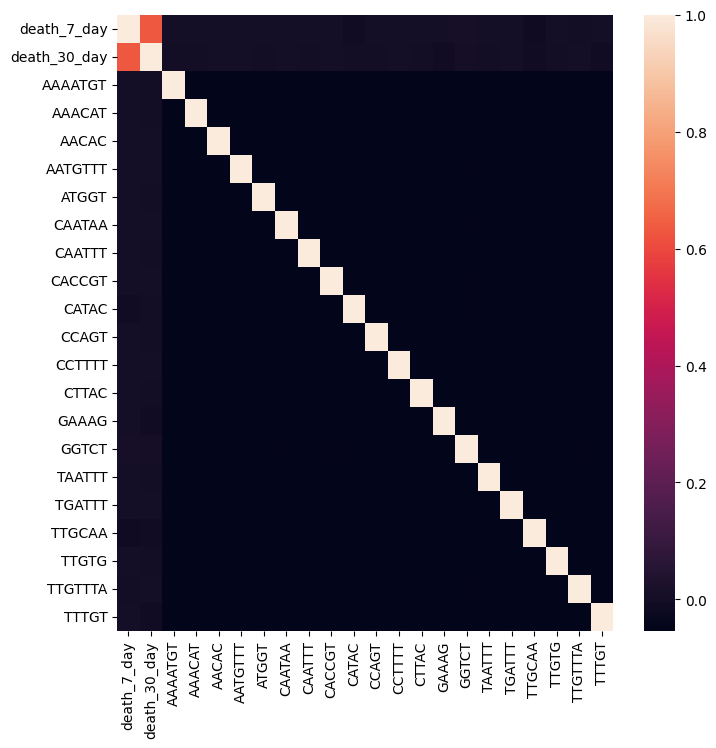

In [195]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr())

### Plot correlations as a heatmap (Log scale)

<Axes: >

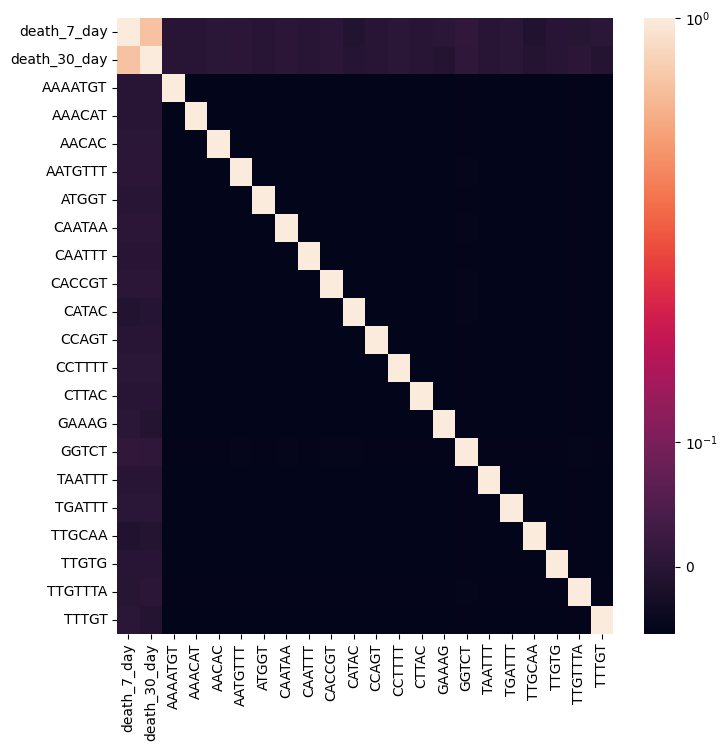

In [196]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr(), norm=SymLogNorm(linthresh=0.3))

### Plot correlations as a heatmap (Log scale - Sorted)

<Axes: >

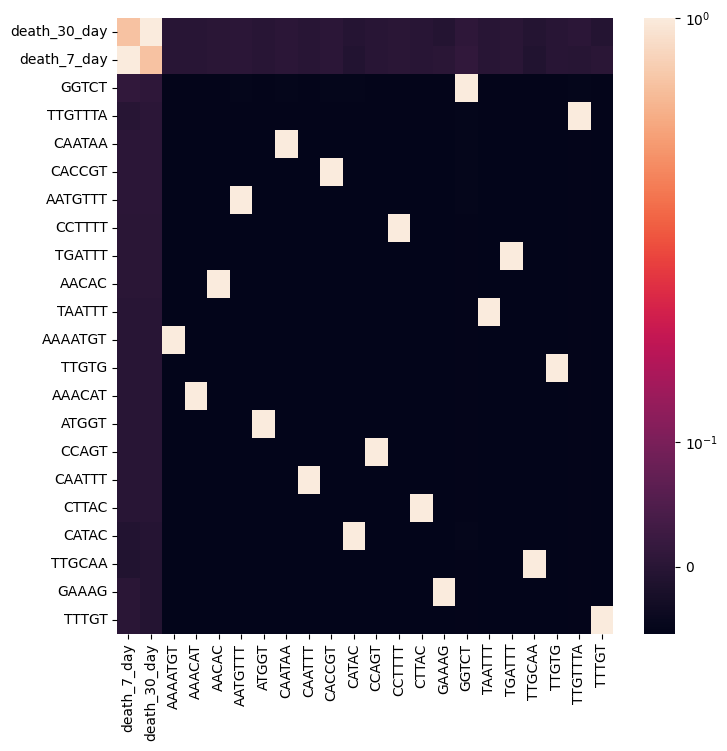

In [197]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False), norm=SymLogNorm(linthresh=0.3))

### Model using machine learning (7 day)

In [198]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day', 'death_7_day'])
y = dataDf.death_7_day

In [199]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.7564575645756457
Balanced Accuracy:  0.4437229437229437
Average Precision:  0.11894698167760899
F1 Score:  0.029411764705882353
ROC AUC:  0.44372294372294374


In [200]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.8782287822878229
Balanced Accuracy:  0.5
Average Precision:  0.12177121771217712
F1 Score:  0.0
ROC AUC:  0.5


In [201]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
6,CAATTT,-0.359696
17,TTGTG,-0.273397
16,TTGCAA,-0.224715
2,AACAC,-0.170321
4,ATGGT,-0.140203
11,CTTAC,-0.092870
15,TGATTT,-0.076482
10,CCTTTT,-0.059773
8,CATAC,-0.042731
5,CAATAA,-0.007607


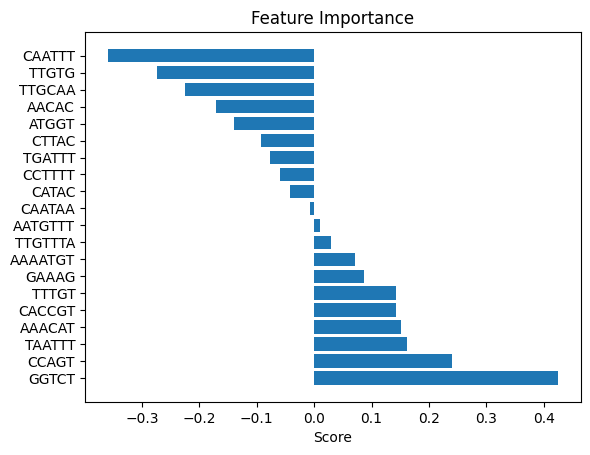

In [202]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()

### Model using machine learning (30 day)

In [203]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day', 'death_7_day'])
y = dataDf.death_30_day

In [204]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.5276752767527675
Balanced Accuracy:  0.40183673469387754
Average Precision:  0.25875370302998807
F1 Score:  0.1232876712328767
ROC AUC:  0.4018367346938776


In [205]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('Average Precision: ', average_precision_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.7232472324723247
Balanced Accuracy:  0.5
Average Precision:  0.2767527675276753
F1 Score:  0.0
ROC AUC:  0.5


In [206]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
6,CAATTT,-0.378518
5,CAATAA,-0.159985
15,TGATTT,-0.144431
16,TTGCAA,-0.124127
11,CTTAC,-0.072362
13,GGTCT,-0.067476
12,GAAAG,-0.045975
4,ATGGT,-0.044678
3,AATGTTT,-0.037998
10,CCTTTT,-0.031136


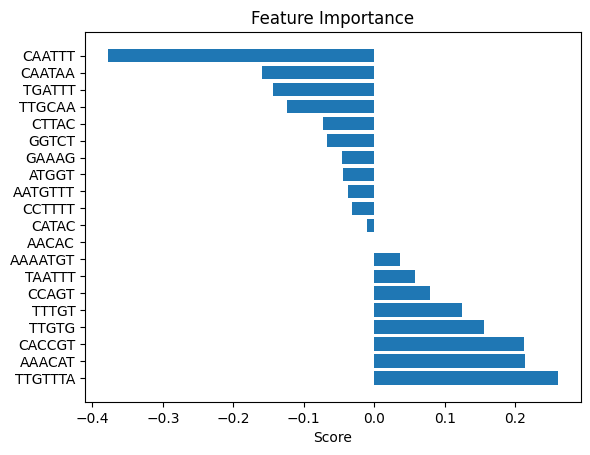

In [207]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()

### Get genes corresponding to the top tokens

#### Token `CAATTT` (-ve feature importance)

In [186]:
highscoreTokenOverlapsDf[highscoreTokenOverlapsDf.tokens == 'CAATTT'][['gene']].value_counts()[:20]

gene 
esae     333
esac     328
leub     122
osmc     119
murt     102
fumc      89
tdh       83
ecsb      82
pqql      77
accc      73
deor      68
sfab      68
sfaa      61
essc      60
lys2b     60
hptr      55
clpb      53
phes      51
rsme      49
hrtb      46
Name: count, dtype: int64

`esae` and `esac`: The type VII secretion system of Staphylococcus aureus secretes a nuclease toxin that targets competitor bacteria. EsaE is a chaperone protein that interacts with the T7SSb components. EsaC, is a secretion substrate of the Ess pathway. 

#### Token `TTGTTTA` (+ve feature importance)

In [187]:
highscoreTokenOverlapsDf[highscoreTokenOverlapsDf.tokens == 'TTGTTTA'][['gene']].value_counts()[:20]

gene 
gltb     108
fadb      86
acob      71
ptsg      58
coba      47
ftsw      47
ebh       41
znua      39
ndh       36
odha      32
asps      30
ilvb      30
phoe      26
ecfa1     26
quec      26
lytm      24
ynbb      21
pola      21
yych      21
ccma      20
Name: count, dtype: int64

`gltB`: gltB deletion mutant showed attenuated virulence. It is identified as a high-confidence drug target